In [1]:
import json

# load the reference corpora
with open('../data/corpus/middle_english_pd_sentence_ngrams.json') as f:
    middle_english_pd_sentence_ngrams = json.load(f)

# load the target corpora
with open('../data/corpus/reddit_sentence_ngrams.json') as f:
    reddit_sentence_ngrams = json.load(f)

In [2]:
"""
The corpora are stored as JSON objects with the following structure:
{
    n-gram": {
            "count": 1,
            "documents": [...]
        }
    }
Convert the JSON object to a dictionary with the following structure:
    1. Split it into 4 dictionaries, one for each n-gram size (2-5)
    2. Each dictionary has n-grams as keys and counts as values
    3. Combine the dictionaries into a single dictionary with n-grams as keys and counts as values
    {
        2: {
            "n-gram": count,
            ...
        }, 
        3: {
            "n-gram": count,
            ...
        },
    ...
    }
"""
def n_dict(ngram_dict):
    n_dict = {}
    for ngram, data in ngram_dict.items():
        n = len(ngram.split())
        if n not in n_dict:
            n_dict[n] = {}
        n_dict[n][ngram] = data['count']
    return n_dict

In [3]:
# convert the JSON objects to dictionaries
middle_english_pd_sentence_ngrams = n_dict(middle_english_pd_sentence_ngrams)

# convert the JSON objects to dictionaries
reddit_sentence_ngrams = n_dict(reddit_sentence_ngrams)

In [4]:
from collections import defaultdict
import math

def compute_pmi_differences(target_counts, ref_counts, n, alpha=1):
    # Step 1: Compute total n-grams and unigrams for each corpus
    total_target_ngrams = sum(target_counts.values())
    total_ref_ngrams = sum(ref_counts.values())
    
    # Unigram counts (for denominator probabilities)
    target_unigram_counts = defaultdict(int)
    ref_unigram_counts = defaultdict(int)
    for ngram, count in target_counts.items():
        for word in ngram:
            target_unigram_counts[word] += count
    for ngram, count in ref_counts.items():
        for word in ngram:
            ref_unigram_counts[word] += count
    total_target_unigrams = sum(target_unigram_counts.values())
    total_ref_unigrams = sum(ref_unigram_counts.values())
    
    # Step 2: Compute PMI differences
    delta_pmi = {}
    all_ngrams = set(target_counts.keys()).union(ref_counts.keys())
    
    for ngram in all_ngrams:
        # Probabilities in target corpus
        target_count = target_counts.get(ngram, 0) + alpha
        target_prob = target_count / (total_target_ngrams + alpha * len(all_ngrams))
        target_individual_probs = [
            (target_unigram_counts.get(word, 0) + alpha) / (total_target_unigrams + alpha * len(target_unigram_counts))
            for word in ngram
        ]
        target_pmi = math.log(target_prob / math.prod(target_individual_probs), 2)
        
        # Probabilities in reference corpus
        ref_count = ref_counts.get(ngram, 0) + alpha
        ref_prob = ref_count / (total_ref_ngrams + alpha * len(all_ngrams))
        ref_individual_probs = [
            (ref_unigram_counts.get(word, 0) + alpha) / (total_ref_unigrams + alpha * len(ref_unigram_counts))
            for word in ngram
        ]
        ref_pmi = math.log(ref_prob / math.prod(ref_individual_probs), 2)
        
        # PMI difference
        delta_pmi[ngram] = target_pmi - ref_pmi
    
    return delta_pmi

# Example usage
target_counts = {
    ('this', 'is'): 10,
    ('corpus', 'is'): 5,
    ('n-grams', 'are'): 2
}
ref_counts = {
    ('this', 'is'): 50,
    ('corpus', 'is'): 10,
    ('n-grams', 'are'): 1
}
n = 2  # For bigrams

delta_pmi = compute_pmi_differences(target_counts, ref_counts, n)
for ngram, delta in delta_pmi.items():
    print(f"ΔPMI({ngram}) = {delta}")

ΔPMI(('this', 'is')) = 0.20224430685568917
ΔPMI(('n-grams', 'are')) = -2.313455531428354
ΔPMI(('corpus', 'is')) = 0.20224430685568873


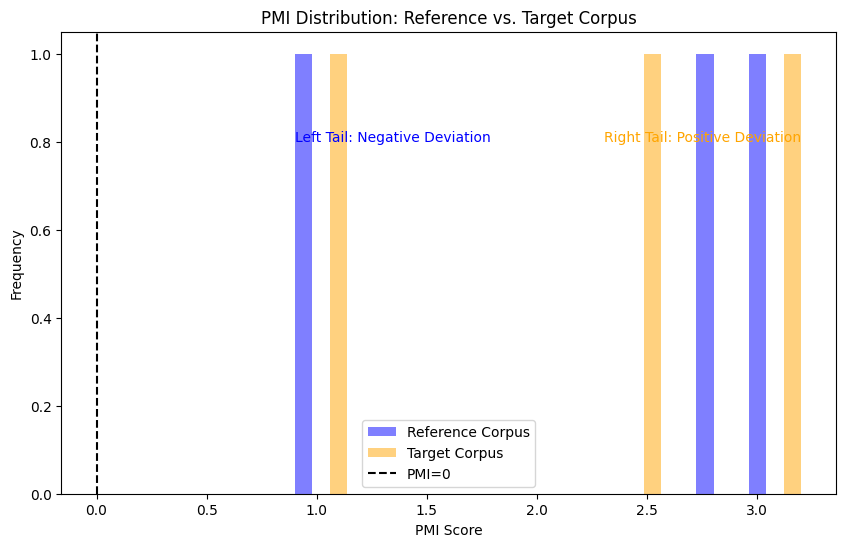

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pmi_histograms(delta_pmi, target_pmis, ref_pmis, bins=30):
    # Prepare data
    all_pmis = list(target_pmis.values()) + list(ref_pmis.values())
    min_pmi, max_pmi = min(all_pmis), max(all_pmis)
    bin_edges = np.linspace(min_pmi, max_pmi, bins)
    
    # Target and reference histograms
    target_hist, _ = np.histogram(list(target_pmis.values()), bins=bin_edges)
    ref_hist, _ = np.histogram(list(ref_pmis.values()), bins=bin_edges)
    
    # Plot histograms
    plt.figure(figsize=(10, 6))
    plt.hist(list(ref_pmis.values()), bins=bin_edges, alpha=0.5, label="Reference Corpus", color="blue")
    plt.hist(list(target_pmis.values()), bins=bin_edges, alpha=0.5, label="Target Corpus", color="orange")
    
    # Add labels and legend
    plt.xlabel("PMI Score")
    plt.ylabel("Frequency")
    plt.title("PMI Distribution: Reference vs. Target Corpus")
    plt.axvline(0, color='black', linestyle='--', label="PMI=0")
    plt.legend()
    
    # Annotate regions
    plt.text(min_pmi, max(target_hist) * 0.8, "Left Tail: Negative Deviation", color="blue", ha="left")
    plt.text(max_pmi, max(target_hist) * 0.8, "Right Tail: Positive Deviation", color="orange", ha="right")
    plt.show()

# Example Data
target_pmis = {('this', 'is'): 3.2, ('corpus', 'is'): 1.1, ('n-grams', 'are'): 2.5}
ref_pmis = {('this', 'is'): 2.8, ('corpus', 'is'): 0.9, ('n-grams', 'are'): 3.0}

plot_pmi_histograms(delta_pmi={}, target_pmis=target_pmis, ref_pmis=ref_pmis)

In [5]:
# compute the PMI differences for each n-gram size across the corpora
pmi_differences = {}

for n in range(2, 6):
    pmi_differences[n] = compute_pmi_differences(
        reddit_sentence_ngrams[n],
        middle_english_pd_sentence_ngrams[n],
        n
    )

# sort the PMI differences by value in descending order
for n in pmi_differences:
    pmi_differences[n] = dict(
        sorted(pmi_differences[n].items(), key=lambda item: item[1], reverse=True)
    )

# save the PMI differences to a JSON file
with open('../data/corpus/pmi_differences.json', 'w') as f:
    json.dump(pmi_differences, f, indent=4)

In [6]:
# show the top 10 PMI differences for each n-gram size
for n in pmi_differences:
    print(f"Top 10 PMI differences for {n}-grams:")
    for i, (ngram, delta) in enumerate(pmi_differences[n].items()):
        print(f"{i+1}. {ngram}: {delta}")
        if i == 9:
            break
    print()

Top 10 PMI differences for 2-grams:
1. 2882888 990930993: 40.519505119367636
2. 078787878787 or: 38.67630995385399
3. damage 078787878787: 38.236891235980906
4. 990930993 3250999: 37.95308368369777
5. like 10131726364656: 37.415925141569446
6. standard 10131726364656: 37.022944559717814
7. bottom 10131730425464: 36.949488618611284
8. tried 10131726364660: 36.79877468770725
9. 10131726364656 set: 36.759356936264524
10. 10131726364656 tension: 36.713680707535104

Top 10 PMI differences for 3-grams:
1. 2882888 990930993 3250999: 55.06649089551172
2. 1619811 12 1241711101: 49.29789707321373
3. 078787878787 or 79: 43.96132909431344
4. 1640we 449 0464460322: 41.649329804156565
5. 1300 gauges 111519283858: 39.38053290994688
6. 1241711101 118 31: 39.10003223573395
7. 12 1241711101 118: 39.02642305238852
8. thereto 2882888 990930993: 38.97780000603703
9. damage 078787878787 or: 37.67352781571222
10. heavy bottom 10131730425464: 36.5337519235099

Top 10 PMI differences for 4-grams:
1. 154 161981